# Part A. Linear Regression From Scratch

## 1. Dataset Use the California Housing dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import time

In [2]:
X_california_housing=fetch_california_housing(as_frame=True).data

In [3]:
X_california_housing.isnull().sum()  ##todo limpio

,0
MedInc,0
HouseAge,0
AveRooms,0
AveBedrms,0
Population,0
AveOccup,0
Latitude,0
Longitude,0


In [4]:
y_california_housing=fetch_california_housing(as_frame=True).target

In [5]:
y_california_housing.isnull().sum()  ##todo limpio

np.int64(0)

In [6]:
X_train, X_test, y_train, y_test= train_test_split(X_california_housing, y_california_housing , test_size=0.2)
standarizer=StandardScaler().fit(X_train)
X_train_standarized=standarizer.transform(X_train)
X_train_standarized.shape

(16512, 8)

## 2. Closed Form Ols

In [7]:
def betas_closed_ols(X, y):
    ### Adding intercept:
    X=np.c_[np.ones(X.shape[0]), X]
    return np.linalg.inv(X.T @ X) @ X.T @ y

In [8]:
betas_closed=betas_closed_ols(X_train_standarized, y_train)

In [9]:
betas_closed

array([ 2.06406878e+00,  8.36984175e-01,  1.14534208e-01, -2.66923913e-01,
        3.14709020e-01, -2.06384660e-03, -3.93528176e-02, -9.14151551e-01,
       -8.87466717e-01])

El valor del intercepto es 2.07 and los betas son: 0.83 (MedInc), 0.12 (HouseAge), -0.27 (AveRooms), 0.30 (AveBedrms), -0.00 (Population), -0.04 (AveOccup), -0.90 (Latitude), -0.87 (Longitude)

In [10]:
def betas_predict(X, betas):
  X=np.c_[np.ones(X.shape[0]), X]
  return X @ betas

In [11]:
X_test_standarized=standarizer.transform(X_test)

In [12]:
y_ols_predicted=betas_predict(X_test_standarized, betas_closed)

In [13]:
def plot_comparisson(y_predicted, y_test):
    error = np.abs(y_predicted - y_test)
    plt.scatter(y_predicted, y_test, c=error, cmap='viridis', alpha=0.6)
    plt.xlabel('y_predicted')
    plt.ylabel('y_test')
    plt.title('Comparison between y_predicted and y_test')
    plt.colorbar(label='Absolute Error')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

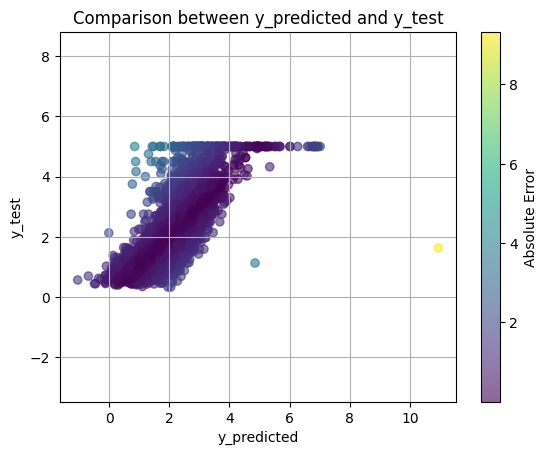

In [14]:
plot_comparisson(y_ols_predicted, y_test)

La solución cerrada muestra una gran dispersión de los errores absolutos. Se muestra cierta correspondencia entre los valores predichos y de test, sin embargo aun dista de ser una recta diagonal simétrica.

## 3. Gradient Descent

In [15]:
def loss_fn(X, beta, y):
    r = y - X @ beta
    return 0.5 * np.mean(r**2)  # escalar (MSE)

In [16]:
def betas_gradient_descent(X, y, n=2e-1, tol=2e-4, max_iters=10_000, seed=42):
    ### Adding intercept:
    X=np.c_[np.ones(X.shape[0]), X]
    X = np.asarray(X, float)
    y = np.asarray(y, float).reshape(-1)
    np.random.seed(seed)
    beta0 = np.random.rand(X.shape[1])
    cost_per_iteration = []

    def grad_fn(X, beta, y):
        r = y - X @ beta
        return -(X.T @ r) / X.shape[0]

    beta = beta0.copy()
    prev = np.inf
    for _ in range(max_iters):
        cost = loss_fn(X, beta, y)
        cost_per_iteration.append(cost)
        g = grad_fn(X, beta, y)
        if np.linalg.norm(g) < tol or abs(prev - cost) < tol:
            break
        prev = cost
        beta = beta - n * g

    return beta, cost_per_iteration


In [17]:
betas_gradient_descent_, cost_iter=betas_gradient_descent(X_train_standarized, y_train)

In [18]:
y_gradient_descent_predicted=betas_predict(X_test_standarized, betas_gradient_descent_)

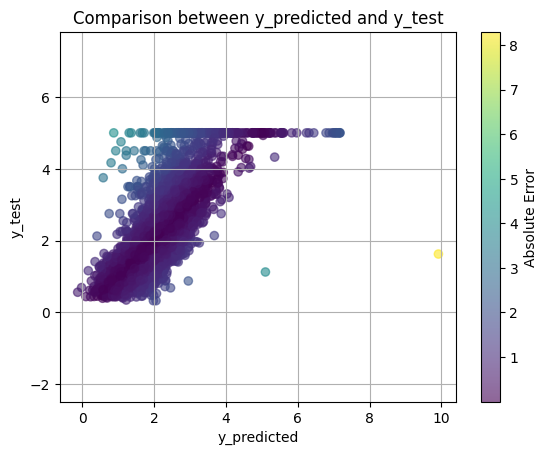

In [19]:
plot_comparisson(y_gradient_descent_predicted, y_test)

En el gradiente descendiente se muestra un grafico de dispersión similar al anterior, de nuevo: hay cierta correspondencia pero dista de ser perfecta.

In [20]:
#Con datos de train
print(f"Closed Solution: {loss_fn(np.c_[np.ones(X_train_standarized.shape[0]), X_train_standarized], betas_closed, y_train)}")
print(f"Gradient Descent: {loss_fn(np.c_[np.ones(X_train_standarized.shape[0]), X_train_standarized], betas_gradient_descent_, y_train)}")

Closed Solution: 0.2598528985537539
Gradient Descent: 0.2681115600840246


In [21]:
#Con datos de test
print(f"Closed Solution: {loss_fn(np.c_[np.ones(X_test_standarized.shape[0]), X_test_standarized], betas_closed, y_test)}")
print(f"Gradient Descent: {loss_fn(np.c_[np.ones(X_test_standarized.shape[0]), X_test_standarized], betas_gradient_descent_, y_test)}")

Closed Solution: 0.27338186301142453
Gradient Descent: 0.27759392810272404


 Mejor rendimiento da la solución cerrada, esto debido a que llega al mínimo teórico posible.

### Comparación entre learning rates

In [22]:
def learning_rate_comparison(l_r, X_train, y_train, X_test, y_test):
    histories = {}

    for lr in l_r:
        betas, cost_iter = betas_gradient_descent(X_train, y_train, n=lr)
        histories[lr] = cost_iter

        y_pred = betas_predict(X_test, betas)
        loss_val = loss_fn(np.c_[np.ones(X_test.shape[0]), X_test], betas, y_test)
        print(f"Learning Rate: {lr}, Final Loss: {loss_val:.6f}")

    # ---- Plot all learning rates together ----
    plt.figure(figsize=(8,5))
    for lr, cost in histories.items():
        plt.plot(cost, label=f"lr={lr}")
    plt.xlabel("Iterations")
    plt.ylabel("Cost")
    plt.title("Cost vs Iterations for different learning rates")
    plt.legend()
    plt.show()

Learning Rate: 0.9, Final Loss: 0.274072
Learning Rate: 0.5, Final Loss: 0.274778
Learning Rate: 0.1, Final Loss: 0.282927
Learning Rate: 0.01, Final Loss: 0.387641
Learning Rate: 0.001, Final Loss: 0.537626


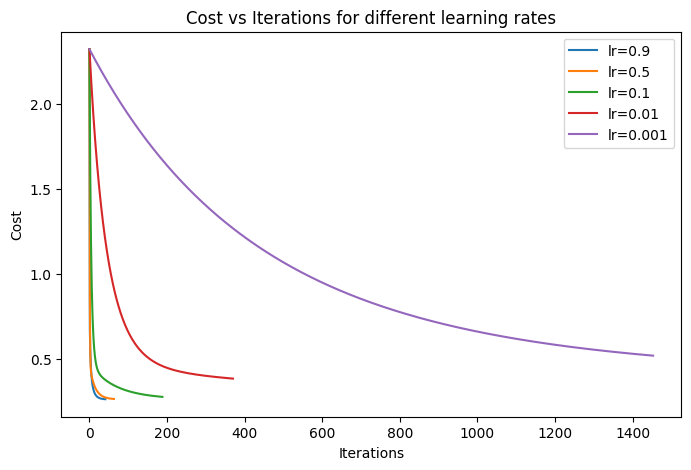

In [23]:
learning_rate_comparison([0.9, 0.5, 0.1, 0.01, 0.001], X_train_standarized, y_train, X_test_standarized, y_test)

A medida que el learning rate aumenta, la convergencia se acelera hasta cierto límite. En este caso, valores como 0.5 o 0.9 permiten alcanzar rápidamente el mínimo (0.259). En cambio, con tasas demasiado pequeñas, el algoritmo converge mucho más despacio y por eso el error final observado es mayor (aunque con más iteraciones también llegaría al mismo mínimo). Es importante notar que con una tasa de aprendizaje demasiado alto el modelo simplemente no converge y se dispara el costo (no se agregó el caso porque rompía la escalas mostradas).


# Parte B

In [24]:
modelo_lr=LinearRegression(fit_intercept=True)
modelo_lr.fit(X_train_standarized, y_train)
modelo_lr.predict(X_test_standarized)

print("Para modelo sklearn:")
print("Intercepto:", modelo_lr.intercept_)
print("Coeficientes:", modelo_lr.coef_)
print("MSE:", mean_squared_error(y_test, modelo_lr.predict(X_test_standarized)))
print("R^2:", r2_score(y_test, modelo_lr.predict(X_test_standarized)))

print("\nPara modelo OLS (solución cerrada):")
print("Betas:", betas_closed)
print("MSE:", mean_squared_error(y_test, y_ols_predicted))
print("R^2:", r2_score(y_test, y_ols_predicted))

print("\nPara modelo Gradient Descent:")
print("Betas:", betas_gradient_descent_)
print("MSE:", mean_squared_error(y_test, y_gradient_descent_predicted))
print("R^2:", r2_score(y_test, y_gradient_descent_predicted))


Para modelo sklearn:
Intercepto: 2.0640687820978756
Coeficientes: [ 0.83698417  0.11453421 -0.26692391  0.31470902 -0.00206385 -0.03935282
 -0.91415155 -0.88746672]
MSE: 0.5467637260228491
R^2: 0.5890527150181977

Para modelo OLS (solución cerrada):
Betas: [ 2.06406878e+00  8.36984175e-01  1.14534208e-01 -2.66923913e-01
  3.14709020e-01 -2.06384660e-03 -3.93528176e-02 -9.14151551e-01
 -8.87466717e-01]
MSE: 0.5467637260228491
R^2: 0.5890527150181977

Para modelo Gradient Descent:
Betas: [ 2.06406878  0.90313864  0.15958643 -0.32960709  0.33864522  0.01316349
 -0.0450727  -0.53072051 -0.50844969]
MSE: 0.5551878562054481
R^2: 0.5827211438804158


La solución cerrada y el modelo sklearn coincide tanto en coeficientes como en métricas. El modelo de gradiente descent tiene diferentes coeficientes mientras que a la vez un ligero menor rendimiento.

# Parte C

## 5. Ridge and Lasso

In [25]:
def ridge_lasso_comparisson(X,y):
  lambdas = np.logspace(-3, 2, 100)

  # Guardar coeficientes
  ridge_coefs = []
  lasso_coefs = []

  for lmbd in lambdas:
      ridge = Ridge(alpha=lmbd, fit_intercept=True).fit(X, y)
      lasso = Lasso(alpha=lmbd, fit_intercept=True, max_iter=10000).fit(X, y)
      ridge_coefs.append(ridge.coef_)
      lasso_coefs.append(lasso.coef_)

  ridge_coefs = np.array(ridge_coefs)
  lasso_coefs = np.array(lasso_coefs)

  # --- Plot Ridge ---
  plt.figure(figsize=(10,5))
  for i in range(ridge_coefs.shape[1]):
      plt.plot(lambdas, ridge_coefs[:, i], label=f"Feature {i}")
  plt.xscale("log")
  plt.xlabel("λ (alpha)")
  plt.ylabel("Coefficient magnitude")
  plt.title("Ridge regularization path")
  plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
            fancybox=True, shadow=True, ncol=5)
  plt.show()

  # --- Plot Lasso ---
  plt.figure(figsize=(10,5))
  for i in range(lasso_coefs.shape[1]):
      plt.plot(lambdas, lasso_coefs[:, i], label=f"Feature {i}")
  plt.xscale("log")
  plt.xlabel("λ (alpha)")
  plt.ylabel("Coefficient magnitude")
  plt.title("Lasso regularization path")
  plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
            fancybox=True, shadow=True, ncol=5)
  plt.show()


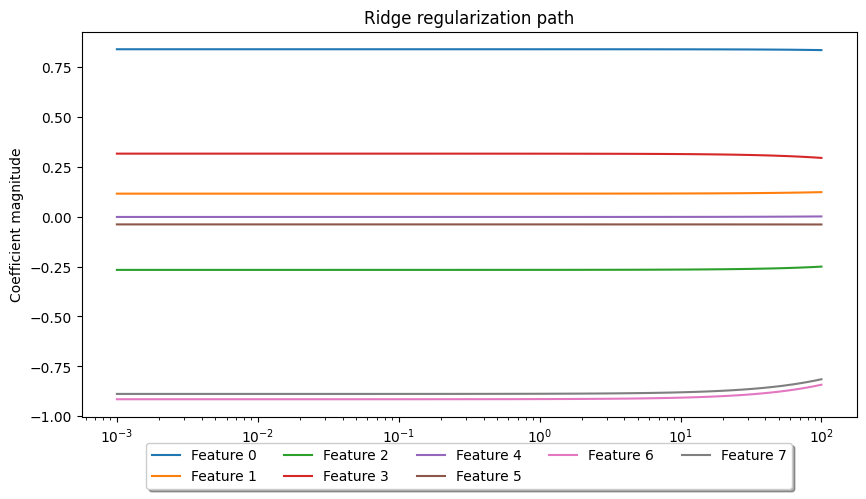

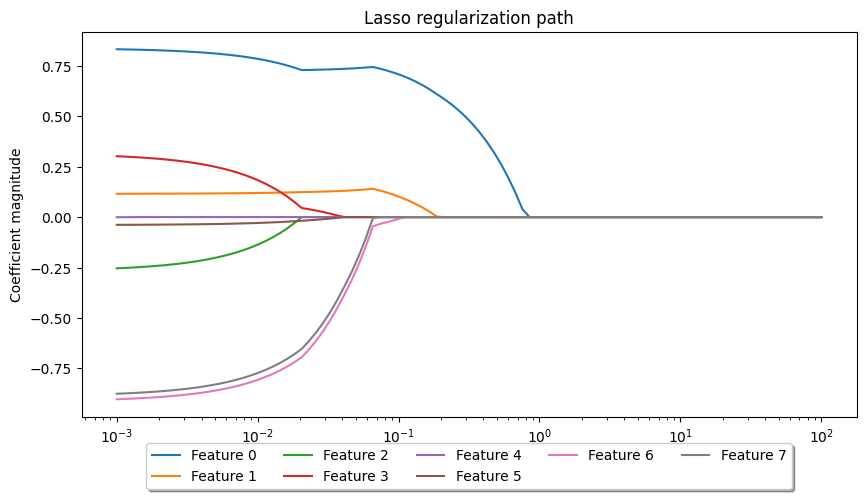

In [26]:
ridge_lasso_comparisson(X_train_standarized,y_train)

Se puede visualizar que dentro del rango seleccionado de los gammas, (entre 10^-3) y (10^2) se produce un efecto diferente en los coeficientes de las regresiones a medida que este valor va creciendo. En el caso de Ridge, los coeficientes tienden a disminuir su valor progresivamente, pero sin mucho cambio notorio y sin llegar nunca a 0. En cambio, en Lasso los coeficientes muestran una mayor contracción y varios se reducen exactamente a cero, lo que implica selección de variables. Se puede ver que el **feature 4 (population)** es prácticamente 0 mientras que el **feature 5 (aveoccup)** está muy cercano a 0 en ambos modelos. A medida que aumenta el valor del penalizador, los coeficientes en lasso van disminuyendo hasta volverse drásticamente 0 en el siguiente orden (Feature 2, Feature 5, Feature 3, Feature 7, Feature 6, Feature 1 y finalmente Feature 0). En ridge disminuyen ligeramente.

In [27]:
#For more detail:
iteracion_feature=0
for i in X_california_housing.columns:
  print(f'Feature {iteracion_feature}: {i}')
  iteracion_feature=iteracion_feature+1

Feature 0: MedInc
Feature 1: HouseAge
Feature 2: AveRooms
Feature 3: AveBedrms
Feature 4: Population
Feature 5: AveOccup
Feature 6: Latitude
Feature 7: Longitude


## 6. K-Fold-Cross-Validation

In [28]:
def ridge_lasso_cv(X, y, alphas=None, cv=5, use_auto=True, random_state=42):
    start = time.time()
    alphas = np.logspace(-3, 2, 50)
    results = {}

    if use_auto:

        # RidgeCV y LassoCV hacen la selección automática
        ridgecv = RidgeCV(alphas=alphas, cv=cv, scoring="neg_mean_squared_error")
        lassocv = LassoCV(alphas=alphas, cv=cv, random_state=random_state, max_iter=10000)
        ridgecv.fit(X, y)
        lassocv.fit(X, y)
        results["Ridge"] = {"best_alpha": ridgecv.alpha_, "cv_mse": -ridgecv.best_score_}
        results["Lasso"] = {"best_alpha": lassocv.alpha_, "cv_mse": mean_squared_error(y, lassocv.predict(X))}

    else:

        # Validación cruzada manual
        kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
        mse_ridge = []
        mse_lasso = []
        for a in alphas:
            ridge = Ridge(alpha=a)
            lasso = Lasso(alpha=a, max_iter=10000)
            cv_ridge = -cross_val_score(ridge, X, y, cv=kf,scoring="neg_mean_squared_error").mean()
            cv_lasso = -cross_val_score(lasso, X, y, cv=kf, scoring="neg_mean_squared_error").mean()
            mse_ridge.append((a, cv_ridge))
            mse_lasso.append((a, cv_lasso))
        best_ridge = min(mse_ridge, key=lambda x: x[1])
        best_lasso = min(mse_lasso, key=lambda x: x[1])
        results["Ridge"] = {"best_alpha": best_ridge[0],"cv_mse": best_ridge[1]}
        results["Lasso"] = {"best_alpha": best_lasso[0],"cv_mse": best_lasso[1]}
    end = time.time()
    print(f"Tiempo de ejecución: {end - start} segundos")
    return results

In [29]:
results = ridge_lasso_cv(X_train_standarized, y_train, use_auto=False) #Se demora mucho más tiempo
print(results)

Tiempo de ejecución: 13.412298202514648 segundos
{'Ridge': {'best_alpha': np.float64(7.543120063354623), 'cv_mse': np.float64(0.5226596020974217)}, 'Lasso': {'best_alpha': np.float64(0.002559547922699536), 'cv_mse': np.float64(0.5221570633718878)}}


In [30]:
results = ridge_lasso_cv(X_train_standarized, y_train, use_auto=True)
print(results)

Tiempo de ejecución: 3.1802241802215576 segundos
{'Ridge': {'best_alpha': np.float64(0.001), 'cv_mse': np.float64(0.521410721377241)}, 'Lasso': {'best_alpha': np.float64(0.001), 'cv_mse': 0.519761420599263}}


Es mucho más eficiente en tiempo de ejecución usar el enfoque de LassoCV y RidgeCV para escoger el alpha. Además se puede ver que en términos del alpha son iguales para Ridge en ambos enfoques, sin embargo para el lasso, este varía ligeramente, probablemente a la forma en la que internamente se realiza la búsqueda en grilla. Por último, con respecto a los errores de test, se puede comprobar que el método de RidgeCV y LassoCV encontraron de manera más optima una mejor generalización (aunque son mínimas), ello puede ser por diferencias en la aleatoriedad del shuffle o también por la forma en que realizan los promedios.

 Resultados finales del ridge y lasso con test:

In [34]:
print("\nPara modelo Ridge:")
modelo_ridge=Ridge(alpha=results['Ridge']['best_alpha']).fit(X_train_standarized, y_train)
betas_ridge=modelo_ridge.coef_
y_ridge_predicted=modelo_ridge.predict(X_test_standarized)
print("Betas:", betas_ridge)
print("MSE:", mean_squared_error(y_test, y_ridge_predicted))
print("R^2:", r2_score(y_test, y_ridge_predicted))

print("\nPara modelo Lasso:")
modelo_lasso=Lasso(alpha=results['Lasso']['best_alpha']).fit(X_train_standarized, y_train)
betas_lasso=modelo_lasso.coef_
y_lasso_predicted=modelo_lasso.predict(X_test_standarized)
print("Betas:", betas_lasso)
print("MSE:", mean_squared_error(y_test, y_lasso_predicted))
print("R^2:", r2_score(y_test, y_lasso_predicted))

print("\n Para modelo sklearn:")
print("Intercepto:", modelo_lr.intercept_)
print("Coeficientes:", modelo_lr.coef_)
print("MSE:", mean_squared_error(y_test, modelo_lr.predict(X_test_standarized)))
print("R^2:", r2_score(y_test, modelo_lr.predict(X_test_standarized)))

print("\nPara modelo OLS (solución cerrada):")
print("Betas:", betas_closed)
print("MSE:", mean_squared_error(y_test, y_ols_predicted))
print("R^2:", r2_score(y_test, y_ols_predicted))

print("\nPara modelo Gradient Descent:")
print("Betas:", betas_gradient_descent_)
print("MSE:", mean_squared_error(y_test, y_gradient_descent_predicted))
print("R^2:", r2_score(y_test, y_gradient_descent_predicted))


Para modelo Ridge:
Betas: [ 0.83698414  0.11453429 -0.26692375  0.3147088  -0.00206382 -0.03935282
 -0.91415075 -0.88746591]
MSE: 0.5467636942392942
R^2: 0.5890527389066983

Para modelo Lasso:
Betas: [ 8.31805102e-01  1.15412806e-01 -2.53921384e-01  3.01650085e-01
 -7.52711305e-04 -3.84300868e-02 -9.02959830e-01 -8.75662627e-01]
MSE: 0.5459149911302085
R^2: 0.5896906236489274

 Para modelo sklearn:
Intercepto: 2.0640687820978756
Coeficientes: [ 0.83698417  0.11453421 -0.26692391  0.31470902 -0.00206385 -0.03935282
 -0.91415155 -0.88746672]
MSE: 0.5467637260228491
R^2: 0.5890527150181977

Para modelo OLS (solución cerrada):
Betas: [ 2.06406878e+00  8.36984175e-01  1.14534208e-01 -2.66923913e-01
  3.14709020e-01 -2.06384660e-03 -3.93528176e-02 -9.14151551e-01
 -8.87466717e-01]
MSE: 0.5467637260228491
R^2: 0.5890527150181977

Para modelo Gradient Descent:
Betas: [ 2.06406878  0.90313864  0.15958643 -0.32960709  0.33864522  0.01316349
 -0.0450727  -0.53072051 -0.50844969]
MSE: 0.555187856

## 7. Feature Engineering & Multicollinearity

In [35]:
X_train_standarized.shape

(16512, 8)

In [36]:
X_train_standarized_polynomial=PolynomialFeatures(degree=2).fit_transform(X_train_standarized)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.571e+02, tolerance: 2.199e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.351e+02, tolerance: 2.199e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.191e+02, tolerance: 2.199e

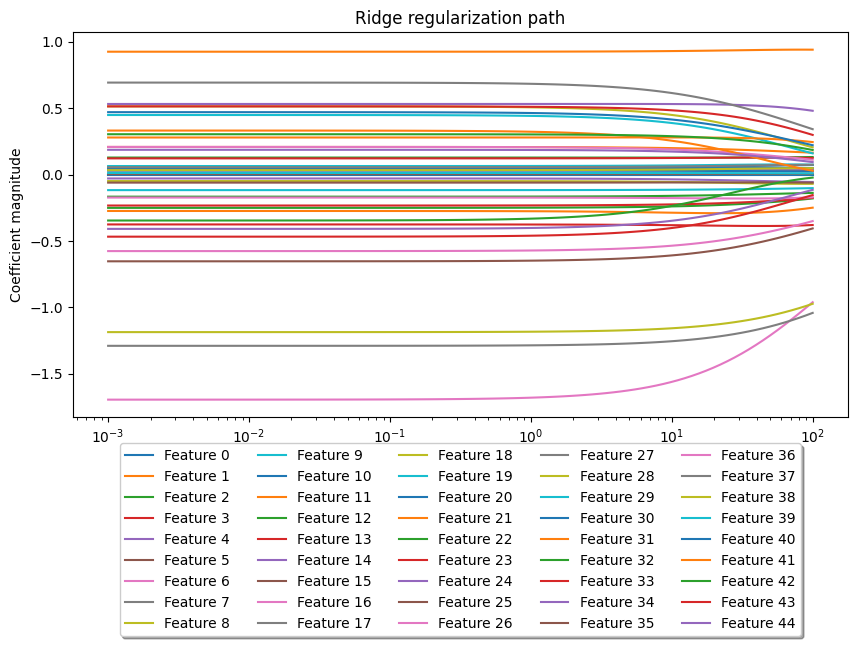

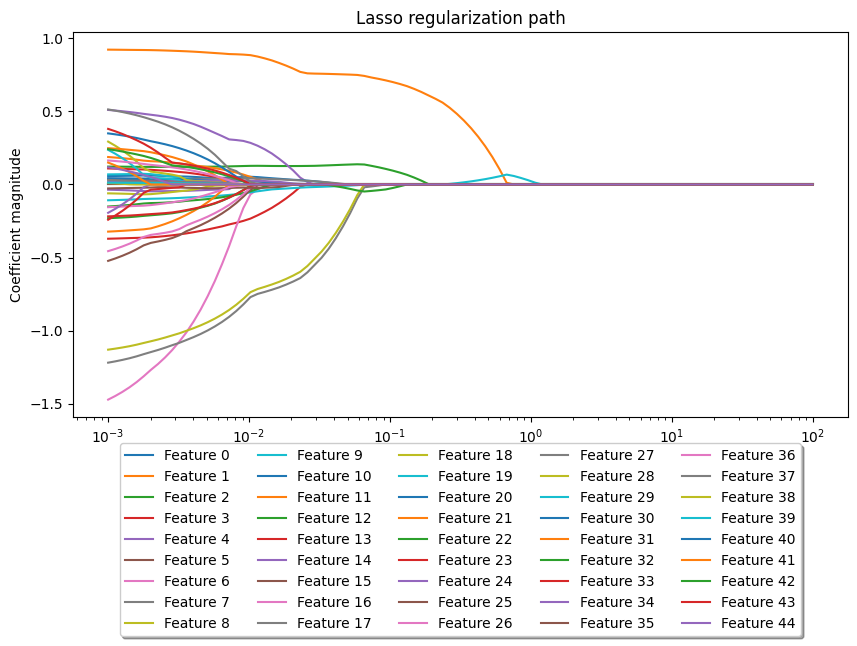

In [37]:
ridge_lasso_comparisson(X_train_standarized_polynomial,y_train)

Se puede ver que con una mayor cantidad de atributos, el penalizador de Ridge hace mucho más efecto. Por otro lado en cuanto a lasso, igualmente hace que a mayor penalizador convergan a 0 exactamente los coeficientes.

# Parte D

In [38]:
hour = pd.read_csv("https://raw.githubusercontent.com/RodrigoGrijalba/ENEI-2025-ML1-Tarea1/main/data/hour.csv", index_col=0)

In [39]:
y=hour["cnt"]

In [40]:
hour['season']=hour['season'].astype('int')

In [41]:
def plot_cnt_with_season_background(df, date_col="dteday", cnt_col="cnt", season_col="season"):

    season_labels = {1: "Spring", 2: "Summer", 3: "Fall", 4: "Winter"}
    colors = {1: "green", 2: "red", 3: "orange", 4: "blue"}

    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(df[date_col], df[cnt_col], color="black", linewidth=1, label="cnt")

    df_sorted = df.sort_values(date_col)
    prev_season = df_sorted.iloc[0][season_col]
    start = df_sorted.iloc[0][date_col]

    for i in range(1, len(df_sorted)):
        current_season = df_sorted.iloc[i][season_col]
        if current_season != prev_season:
            end = df_sorted.iloc[i-1][date_col]
            ax.axvspan(start, end, color=colors.get(prev_season, "gray"), alpha=0.2,
                       label=season_labels.get(prev_season, prev_season))
            start = df_sorted.iloc[i][date_col]
            prev_season = current_season

    ax.axvspan(start, df_sorted.iloc[-1][date_col],
               color=colors.get(prev_season, "gray"), alpha=0.2,
               label=season_labels.get(prev_season, prev_season))

    ax.set_title("Bike rentals (cnt) with seasonal background")
    ax.set_xlabel("Date")
    ax.set_ylabel("Count")
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    plt.show()

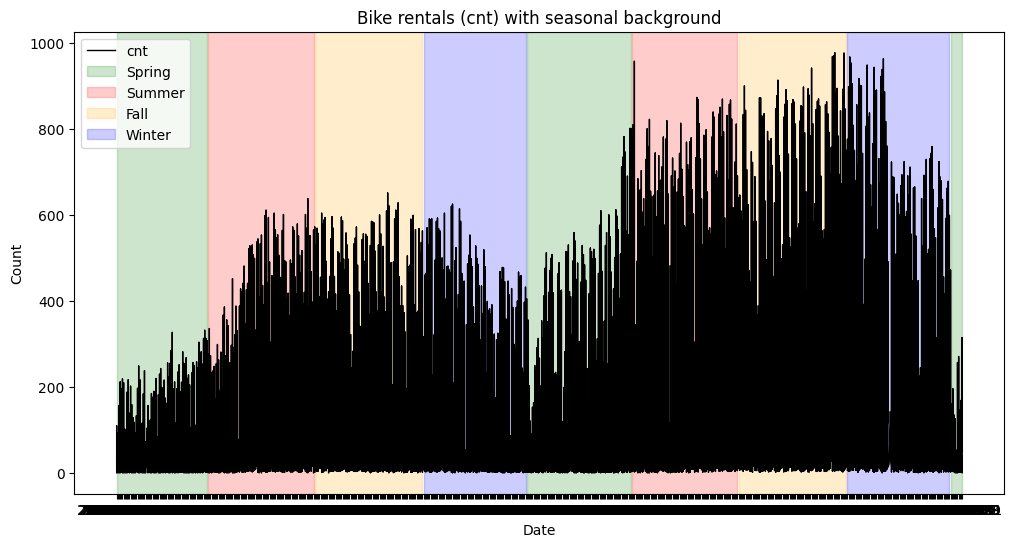

In [42]:
plot_cnt_with_season_background(hour)

Hay una tendencia creciente en todo el periodo analizado. La renta de las bicicletas muestran una estacionalidad anual caracterizada como una crecida de la renta entre primavera y verano, una estabilización entre verano y otoño y una caída en invierno.

In [43]:
hour.sort_values(by=['dteday', 'hr'], inplace=True)

In [44]:
X_bycicles=hour.drop(['dteday', 'cnt', 'casual', 'registered'], axis=1)

***No se considera casual ni registered porque puede dar lugar a data leakage***

In [45]:
y_bycicles=hour['cnt']

## Parte A

In [46]:
X_train_bicycles, X_test_bicycles, y_train_bicycles, y_test_bicycles= train_test_split(X_bycicles, y_bycicles , test_size=0.2, shuffle=False)
standarizer=StandardScaler().fit(X_train_bicycles)
X_train_bicycles_standarized=standarizer.transform(X_train_bicycles)

### Closed Form OLS

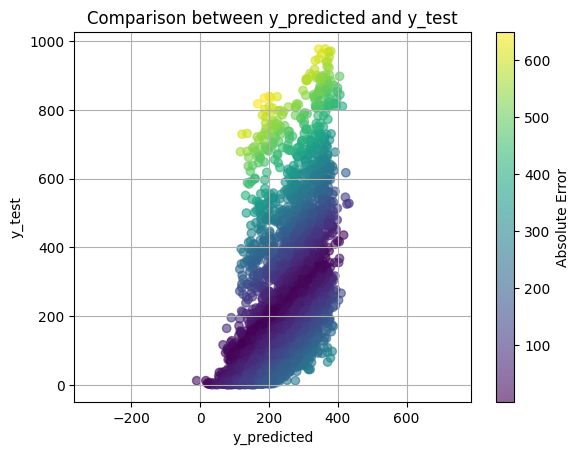

In [47]:
betas_closed=betas_closed_ols(X_train_bicycles_standarized, y_train_bicycles)
X_test_bicycles_standarized=standarizer.transform(X_test_bicycles)
y_ols_predicted=betas_predict(X_test_bicycles_standarized, betas_closed)
plot_comparisson(y_ols_predicted, y_test_bicycles)

Se puede visualizar una ligero efecto de predicción, sin embargo, igual existe una gran diferencia entre los valores predichos y los valores reales (el grafico está muy lejos de ser una linea diagonal perfecta). Los valores predichos de y no tienden a ser muy altos a comparación del valor de y de test, lo que hace que el error aumente para valores más altos del y real

In [48]:
betas_closed

array([174.63914263,   8.55354078,  37.24418594,   8.06348204,
        50.10300473,  -3.45448443,   2.51693071,   0.38340467,
        -3.4064075 ,  15.82868619,  37.87324361, -33.45258038,
         4.10173811])

El intercepto tiene 174.64. El coeficiente de season es 8.55, el coeficiente de yr es 37.24, el coeficiente de mnth es  8.06, el coeficiente de hr es 50.10, el coeficiente de holiday es -3.45, el coeficiente de weekday es  2.52, el coeficiente de workingday es 0.38, el coeficiente de weathersit es -3.41, el coeficiente de temp es 15.83, el coeficiente de atemp es 37.87, el coeficiente de hum es -33.45  y el coeficiente de windspeed es 4.10.


174.63914263,   8.55354078,  37.24418594,   8.06348204,
        50.10300473,  -3.45448443,   2.51693071,   0.38340467,
        -3.4064075 ,  15.82868619,  37.87324361, -33.45258038,
         4.10173811

### Gradient Descent

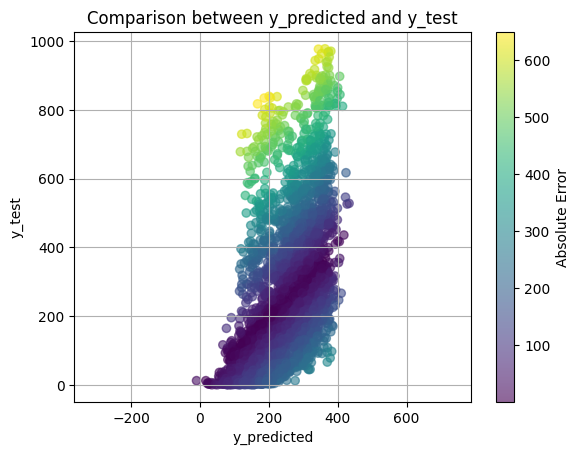

In [49]:
betas_gradient_descent_, cost_iter=betas_gradient_descent(X_train_bicycles_standarized, y_train_bicycles)
y_gradient_descent_predicted=betas_predict(X_test_bicycles_standarized, betas_gradient_descent_)
plot_comparisson(y_gradient_descent_predicted, y_test_bicycles)

Se observa el mismo patrón que la solución cerrada

In [50]:
print(f"Closed Solution: {loss_fn(np.c_[np.ones(X_test_bicycles_standarized.shape[0]), X_test_bicycles_standarized], betas_closed, y_test_bicycles)}")
print(f"Gradient Descent: {loss_fn(np.c_[np.ones(X_test_bicycles_standarized.shape[0]), X_test_bicycles_standarized], betas_gradient_descent_, y_test_bicycles)}")

Closed Solution: 16795.384657315793
Gradient Descent: 16796.829971341707


Nuevamente se observa un mejor desempeño de la solución cerrada.

In [51]:
betas_gradient_descent_

array([174.63914263,   8.50662676,  37.25230553,   8.10412532,
        50.1132586 ,  -3.47480283,   2.51212012,   0.3891167 ,
        -3.42530381,  19.09468044,  34.60532895, -33.41570794,
         3.98853524])

In [52]:
betas_closed

array([174.63914263,   8.55354078,  37.24418594,   8.06348204,
        50.10300473,  -3.45448443,   2.51693071,   0.38340467,
        -3.4064075 ,  15.82868619,  37.87324361, -33.45258038,
         4.10173811])

Los parámetros son bastante similares entre sí, pero en algunos casos los de la solución cerrada es notoriamente mayor o menor que el de la solución de gradiente descendente.

### Comparación entre learning rates

Learning Rate: 0.6, Final Loss: 16796.142841
Learning Rate: 0.5, Final Loss: 16796.227730
Learning Rate: 0.1, Final Loss: 16797.601247
Learning Rate: 0.01, Final Loss: 16795.624963
Learning Rate: 0.001, Final Loss: 16805.957919


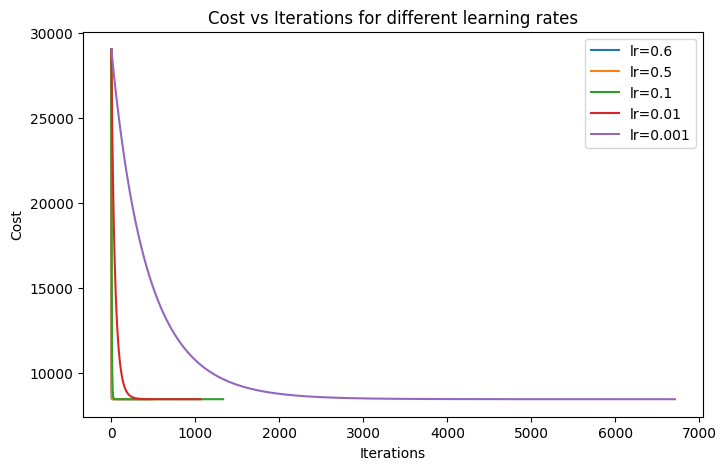

In [53]:
learning_rate_comparison([0.6, 0.5, 0.1, 0.01, 0.001], X_train_bicycles_standarized, y_train_bicycles, X_test_bicycles_standarized, y_test_bicycles)

Se puede ver que a mayor learning rate, es menor el número de iteraciones que se necesita para converger al error mínimo posible (de la solución cerrada).

## Parte B

In [54]:
modelo_lr=LinearRegression(fit_intercept=True)
modelo_lr.fit(X_train_bicycles_standarized, y_train_bicycles)
modelo_lr.predict(X_test_bicycles_standarized)

print("Para modelo sklearn:")
print("Intercepto:", modelo_lr.intercept_)
print("Coeficientes:", modelo_lr.coef_)
print("MSE:", mean_squared_error(y_test_bicycles, modelo_lr.predict(X_test_bicycles_standarized)))
print("R^2:", r2_score(y_test_bicycles, modelo_lr.predict(X_test_bicycles_standarized)))

print("\nPara modelo OLS (solución cerrada):")
print("Betas:", betas_closed)
print("MSE:", mean_squared_error(y_test_bicycles, y_ols_predicted))
print("R^2:", r2_score(y_test_bicycles, y_ols_predicted))

print("\nPara modelo Gradient Descent:")
print("Betas:", betas_gradient_descent_)
print("MSE:", mean_squared_error(y_test_bicycles, y_gradient_descent_predicted))
print("R^2:", r2_score(y_test_bicycles, y_gradient_descent_predicted))


Para modelo sklearn:
Intercepto: 174.63914263108683
Coeficientes: [  8.55354078  37.24418594   8.06348204  50.10300473  -3.45448443
   2.51693071   0.38340467  -3.4064075   15.82868619  37.87324361
 -33.45258038   4.10173811]
MSE: 33590.769314631616
R^2: 0.30902462052952717

Para modelo OLS (solución cerrada):
Betas: [174.63914263   8.55354078  37.24418594   8.06348204  50.10300473
  -3.45448443   2.51693071   0.38340467  -3.4064075   15.82868619
  37.87324361 -33.45258038   4.10173811]
MSE: 33590.76931463159
R^2: 0.3090246205295277

Para modelo Gradient Descent:
Betas: [174.63914263   8.50662676  37.25230553   8.10412532  50.1132586
  -3.47480283   2.51212012   0.3891167   -3.42530381  19.09468044
  34.60532895 -33.41570794   3.98853524]
MSE: 33593.659942683415
R^2: 0.3089651591698813


La solución cerrada y el modelo sklearn coincide tanto en coeficientes como en métricas. El modelo de gradiente descent tiene diferentes coeficientes mientras que a la vez un ligero menor rendimiento.

## Parte C

 ### Ridge and Lasso:

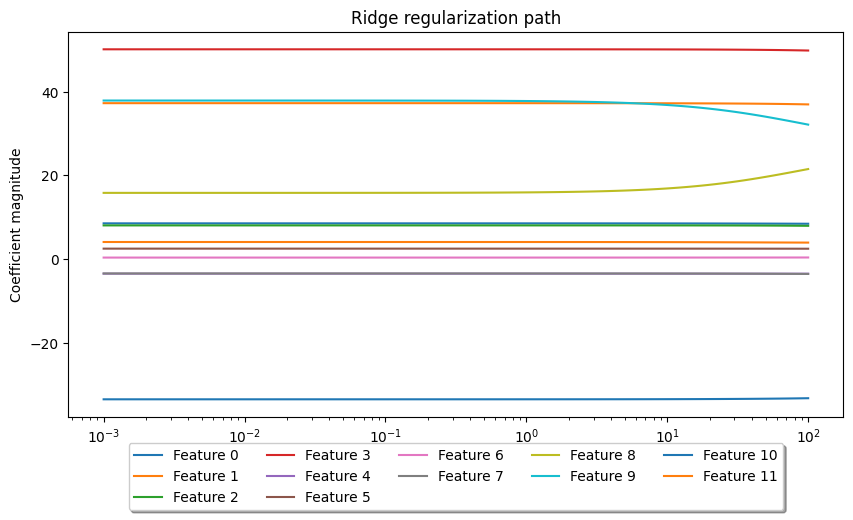

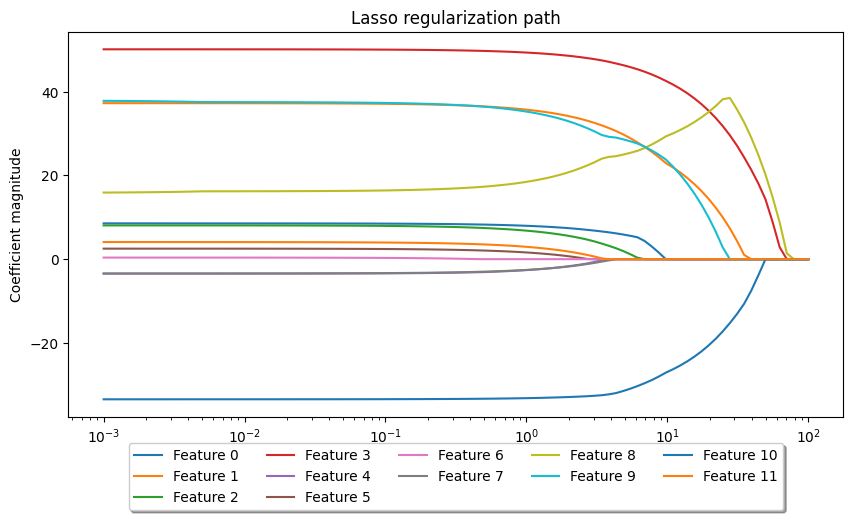

In [55]:
ridge_lasso_comparisson(X_train_bicycles_standarized,y_train_bicycles)


Se puede visualizar que dentro del rango seleccionado de los gammas, (entre 10^-3) y (10^2) se produce un efecto diferente en los coeficientes de las regresiones a medida que este valor va creciendo. En el caso de Ridge, los coeficientes tienden a disminuir su valor progresivamente, pero sin mucho cambio notorio y sin llegar nunca a 0. En cambio, en Lasso los coeficientes muestran una mayor contracción y varios se reducen exactamente a cero, lo que implica selección de variables. Se puede ver que el **feature 6 (working day)** es practicamente 0 mientras que el **feature 5 (weekday) y 1 (yr)** están muy cercanos a 0 en ambos modelos. A medida que aumenta el valor del penalizador, los coeficientes en lasso (no en ridge) van disminuyendo hasta volverse 0 en el siguiente orden (**Feature 5, Feature 11, Feature 7, Feature 2, Feature 0, Feature 9 y Feature 11, Feature 10, Feature 3 y finalmente Feature 8**)

In [56]:
#For more detail:
iteracion_feature=0
for i in X_bycicles.columns:
  print(f'Feature {iteracion_feature}: {i}')
  iteracion_feature=iteracion_feature+1

Feature 0: season
Feature 1: yr
Feature 2: mnth
Feature 3: hr
Feature 4: holiday
Feature 5: weekday
Feature 6: workingday
Feature 7: weathersit
Feature 8: temp
Feature 9: atemp
Feature 10: hum
Feature 11: windspeed


 ### K-Fold-Cross-Validation


In [57]:
results = ridge_lasso_cv(X_train_bicycles_standarized, y_train_bicycles, use_auto=True)
print(results)
results = ridge_lasso_cv(X_train_bicycles_standarized, y_train_bicycles, use_auto=False) #Se demora mucho más tiempo
print(results)


Tiempo de ejecución: 2.2825875282287598 segundos
{'Ridge': {'best_alpha': np.float64(100.0), 'cv_mse': np.float64(18588.266198366222)}, 'Lasso': {'best_alpha': np.float64(1.8420699693267164), 'cv_mse': 16939.536854956707}}
Tiempo de ejecución: 16.82320237159729 segundos
{'Ridge': {'best_alpha': np.float64(30.88843596477485), 'cv_mse': np.float64(16950.754881845514)}, 'Lasso': {'best_alpha': np.float64(0.10985411419875583), 'cv_mse': np.float64(16950.797694724344)}}


Nuevamente se puede ver que el CV demora menos tiempo con el método de LassoCV y RidgeCV. Los resultados (mse), sin embargo, esta vez varía. Para el Ridge Manual es mejor que el RidgeCV, más no lo mismo con el Lasso Manual con respecto al LassoCV

In [60]:
print("\nPara modelo Ridge:")
modelo_ridge=Ridge(alpha=results['Ridge']['best_alpha']).fit(X_train_bicycles_standarized, y_train_bicycles)
betas_ridge=modelo_ridge.coef_
y_bicycles_ridge_predicted=modelo_ridge.predict(X_test_bicycles_standarized)
print("Betas:", betas_ridge)
print("MSE:", mean_squared_error(y_test_bicycles, y_bicycles_ridge_predicted))
print("R^2:", r2_score(y_test_bicycles, y_bicycles_ridge_predicted))

print("\nPara modelo Lasso:")
modelo_lasso=Lasso(alpha=results['Lasso']['best_alpha']).fit(X_train_bicycles_standarized, y_train_bicycles)
betas_lasso=modelo_lasso.coef_
y_bicycles_lasso_predicted=modelo_lasso.predict(X_test_bicycles_standarized)
print("Betas:", betas_lasso)
print("MSE:", mean_squared_error(y_test_bicycles, y_bicycles_lasso_predicted))
print("R^2:", r2_score(y_test_bicycles, y_bicycles_lasso_predicted))

print("\n Para modelo sklearn:")
print("Intercepto:", modelo_lr.intercept_)
print("Coeficientes:", modelo_lr.coef_)
print("MSE:", mean_squared_error(y_test_bicycles, modelo_lr.predict(X_test_bicycles_standarized)))
print("R^2:", r2_score(y_test_bicycles, modelo_lr.predict(X_test_bicycles_standarized)))

print("\nPara modelo OLS (solución cerrada):")
print("Betas:", betas_closed)
print("MSE:", mean_squared_error(y_test_bicycles, y_ols_predicted))
print("R^2:", r2_score(y_test_bicycles, y_ols_predicted))

print("\nPara modelo Gradient Descent:")
print("Betas:", betas_gradient_descent_)
print("MSE:", mean_squared_error(y_test_bicycles, y_gradient_descent_predicted))
print("R^2:", r2_score(y_test_bicycles, y_gradient_descent_predicted))



Para modelo Ridge:
Betas: [  8.51103893  37.15468406   8.04327384  50.01548279  -3.46252076
   2.50960501   0.39138062  -3.44935637  18.55482152  35.12753192
 -33.36081005   4.02416251]
MSE: 33606.53223762172
R^2: 0.3087003709836881

Para modelo Lasso:
Betas: [  8.48300651  37.07395011   7.92985801  50.01802542  -3.37542488
   2.41681771   0.29436983  -3.3129377   16.43266579  37.27456162
 -33.41889971   3.96500126]
MSE: 33618.043684526376
R^2: 0.3084635759785278

 Para modelo sklearn:
Intercepto: 174.63914263108683
Coeficientes: [  8.55354078  37.24418594   8.06348204  50.10300473  -3.45448443
   2.51693071   0.38340467  -3.4064075   15.82868619  37.87324361
 -33.45258038   4.10173811]
MSE: 33590.769314631616
R^2: 0.30902462052952717

Para modelo OLS (solución cerrada):
Betas: [174.63914263   8.55354078  37.24418594   8.06348204  50.10300473
  -3.45448443   2.51693071   0.38340467  -3.4064075   15.82868619
  37.87324361 -33.45258038   4.10173811]
MSE: 33590.76931463159
R^2: 0.3090246

 ### Feature Engineering

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.375e+05, tolerance: 3.875e+04
  model = cd_fast.enet_coordinate_descent(


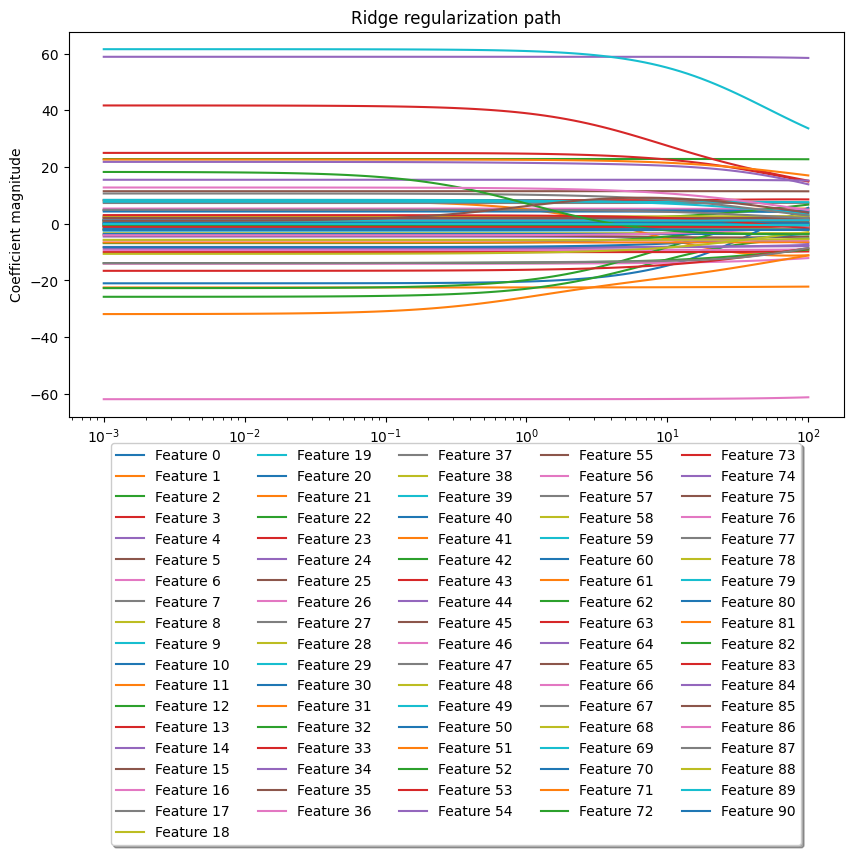

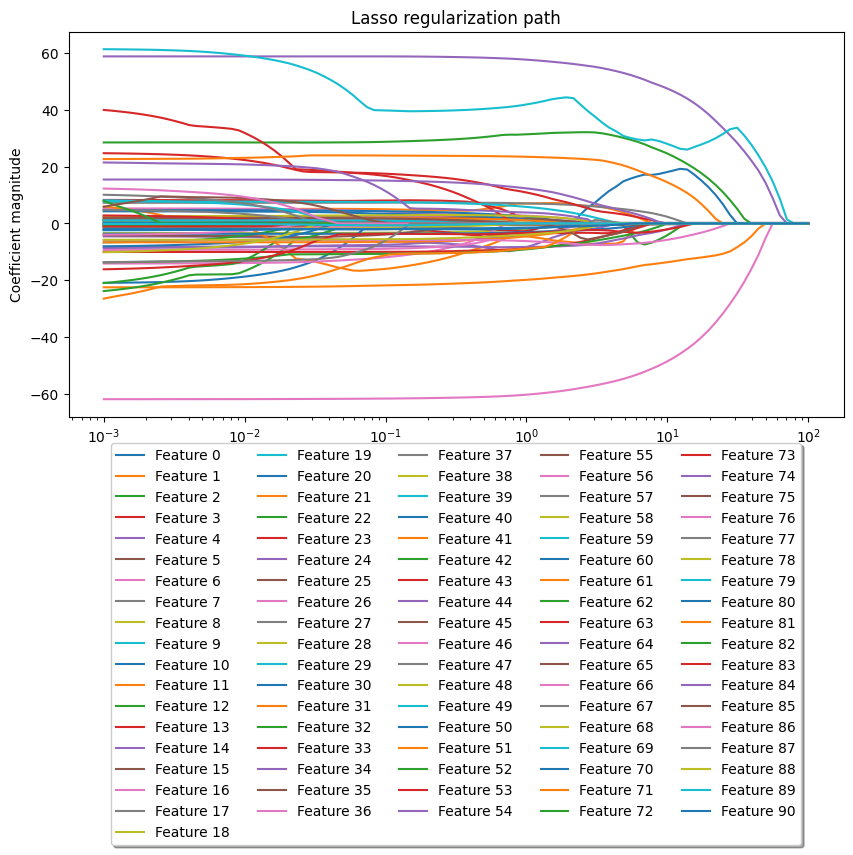

In [59]:

X_train_bicycles_standarized_polynomial=PolynomialFeatures(degree=2).fit_transform(X_train_bicycles_standarized)
ridge_lasso_comparisson(X_train_bicycles_standarized_polynomial,y_train_bicycles)


Se puede ver que con una mayor cantidad de atributos, el penalizador de Ridge hace mucho más efecto. Por otro lado en cuanto a lasso, igualmente hace que a mayor penalizador convergan a 0 exactamente los coeficientes.